In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 0


In [5]:
# Enable XLA Optimization for Speedup
tf.config.optimizer.set_jit(True)

In [7]:
train_path ="fer dataset/"
test_path = "fer dataset/"
picture_size = 48

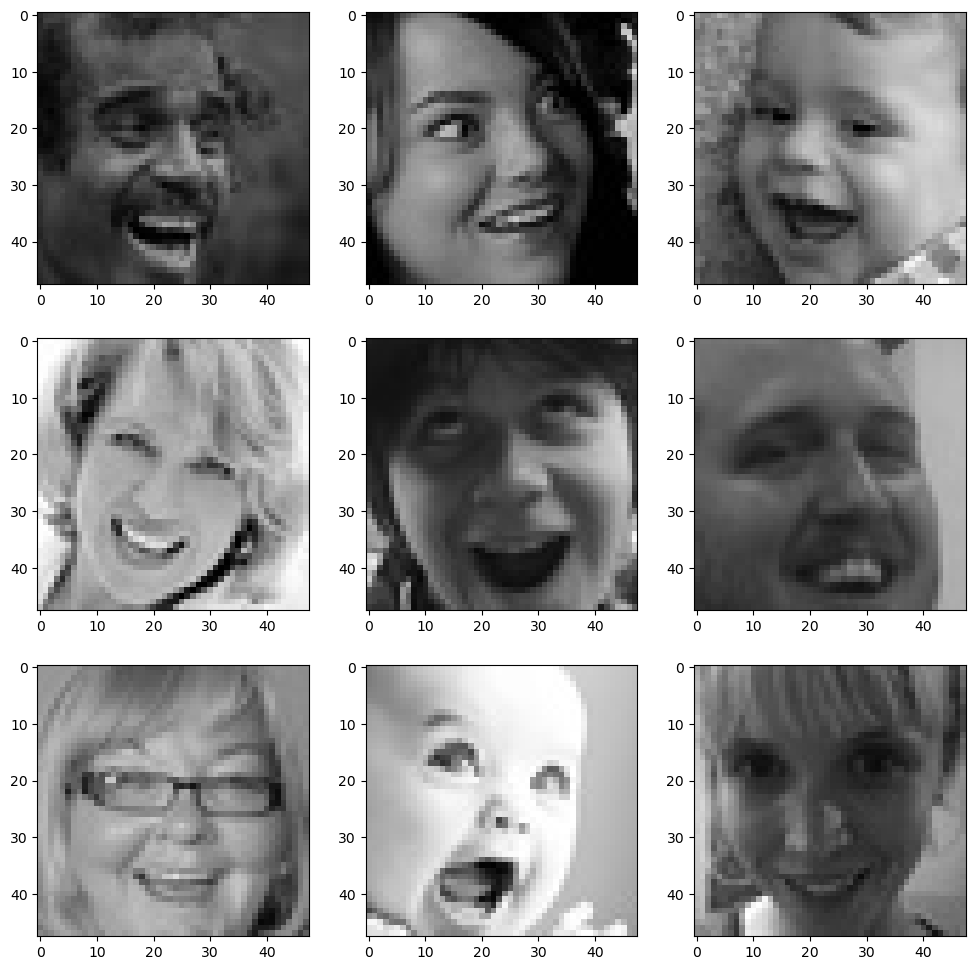

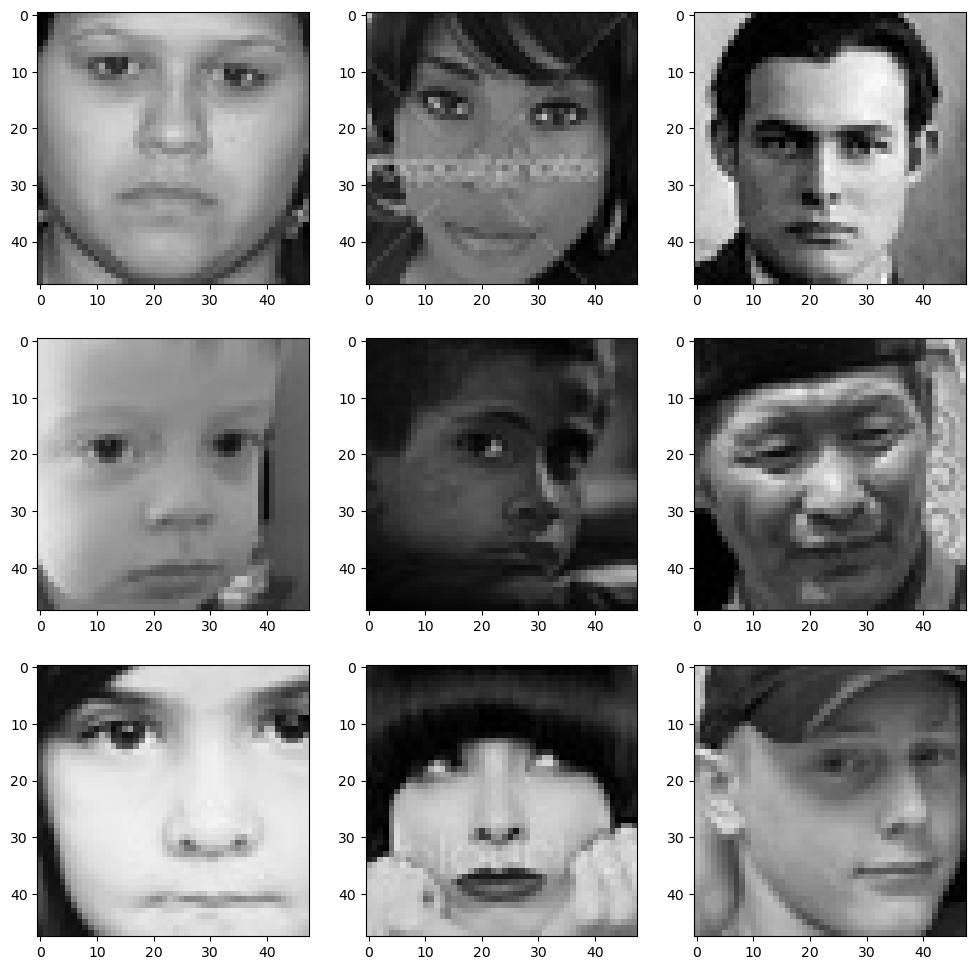

In [9]:
# Display Sample Images
def display_images(expression):
    plt.figure(figsize=(12, 12))
    for i in range(1, 10, 1):
        plt.subplot(3, 3, i)
        img = load_img(train_path + "train/" + expression + "/" +
                       os.listdir(train_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
        plt.imshow(img)
    plt.show()

display_images('happy')
display_images('neutral')

In [11]:
# Data Augmentation with Multi-threading Enabled
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen_val = ImageDataGenerator(rescale=1./255)

In [13]:
# Load datasets
batch_size = 64
train_set = datagen_train.flow_from_directory(train_path + "train",
                                              target_size=(picture_size, picture_size),
                                              color_mode="grayscale",
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              shuffle=True)

test_set = datagen_val.flow_from_directory(test_path + "test",
                                           target_size=(picture_size, picture_size),
                                           color_mode="grayscale",
                                           batch_size=batch_size,
                                           class_mode="categorical",
                                           shuffle=False)

Found 12180 images belonging to 2 classes.
Found 3007 images belonging to 2 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# FINAL OUTPUT LAYER - FIXED
model.add(Dense(2, activation='softmax'))  # ✅ 2 output classes now

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


C:\Users\sohan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compile Model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
checkpoint = ModelCheckpoint("./model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 838,402 (3.20 MB)

 Trainable params: 838,402 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=5,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    callbacks=callbacks_list
)

Epoch 1/5


C:\Users\sohan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5815 - loss: 0.6813
Epoch 1: val_accuracy improved from -inf to 0.60258, saving model to ./model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accuracy: 0.5815 - loss: 0.6813 - val_accuracy: 0.6026 - val_loss: 0.6792 - learning_rate: 1.0000e-04
Epoch 2/5
  1/190 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5625 - loss: 0.6901

C:\Users\sohan\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.60258
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5625 - loss: 0.6901 - val_accuracy: 0.6026 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5873 - loss: 0.6757
Epoch 3: val_accuracy did not improve from 0.60258
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.5873 - loss: 0.6757 - val_accuracy: 0.6026 - val_loss: 0.6740 - learning_rate: 1.0000e-04
Epoch 4/5
  1/190 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5000 - loss: 0.7279
Epoch 4: val_accuracy did not improve from 0.60258
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5000 - loss: 0.7279 - val_accuracy: 0.6026 - val_loss: 0.6739 - learning_rate: 1.0000e-04
Epoch 5/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5993 - loss: 0.6703
Epoch 5: val_accuracy improved from 0.60258 to 0.60292, saving model to ./model.keras
190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.5992 -

In [21]:
model.save('face_emotion_model.keras')

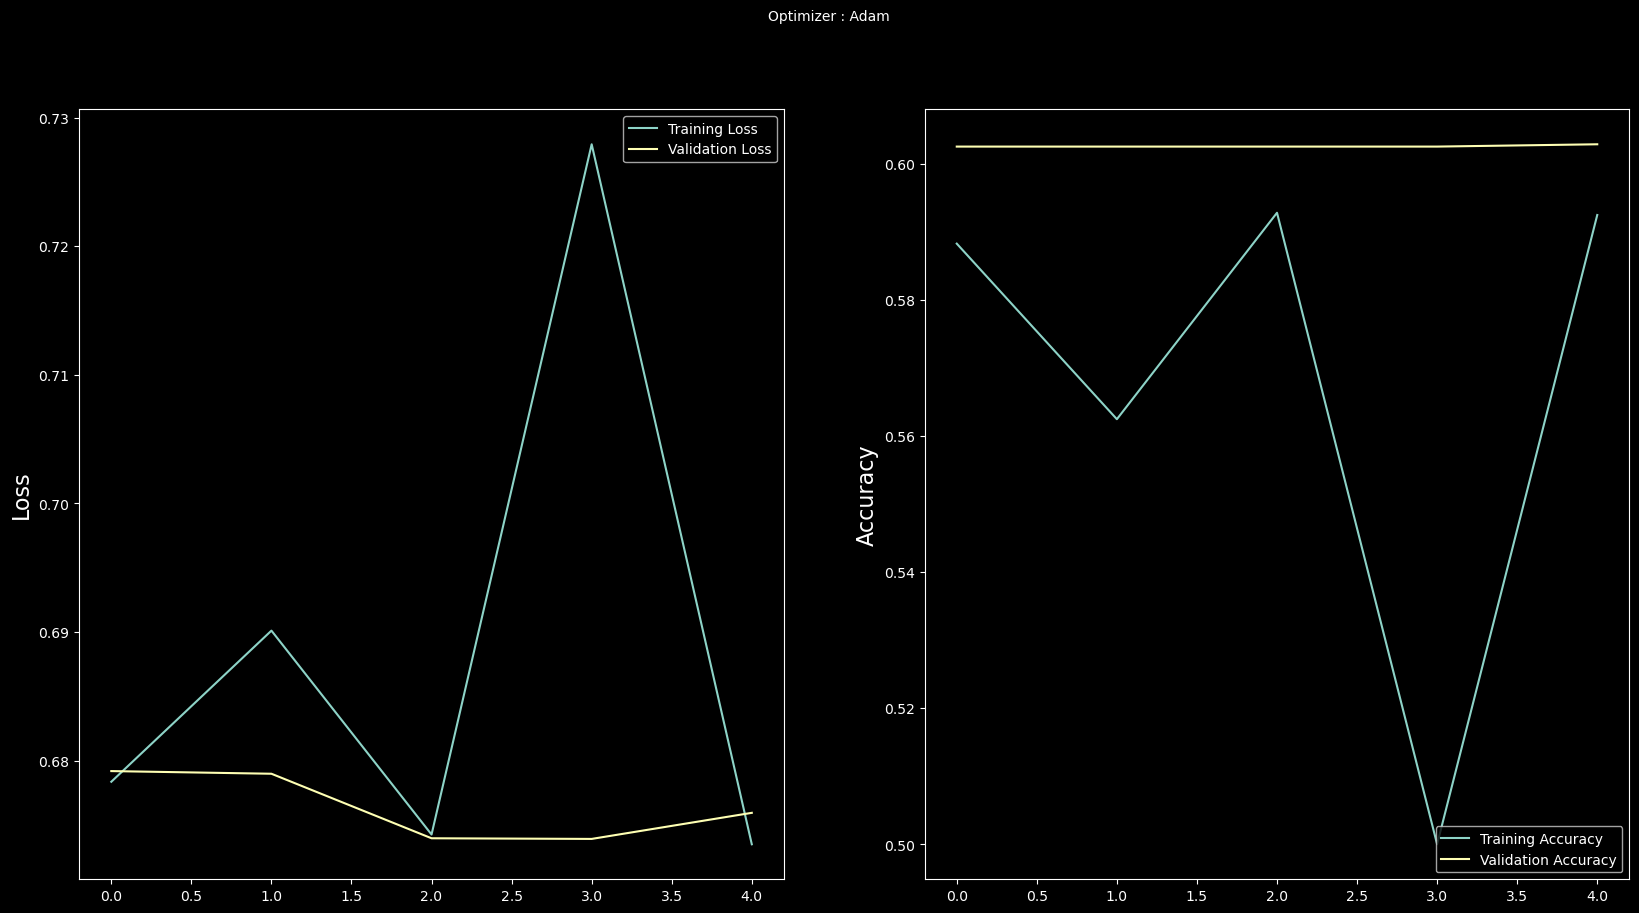

In [23]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [25]:
import numpy as np
from keras.models import load_model
import cv2
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from time import sleep

## Face Emotion Detecting using Pre-trained Model

In [28]:
face_classifier = cv2.CascadeClassifier(r"C:\Users\sohan\OneDrive\Desktop\haarcascade_frontalface_default.xml")
classifier =load_model(r'model.keras')

emotion_labels = ['Happy', 'Neutral']

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Cannot open camera")
    exit()

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("❌ Failed to grab frame")
        break

    labels = []
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,255), 2)
        roi_gray = gray[y:y + h, x:x + w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray]) != 0:
            roi = roi_gray.astype('float') / 255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi, axis=0)

            prediction = classifier.predict(roi)[0]
            label = emotion_labels[prediction.argmax()]
            label_position = (x, y - 10)
            cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else:
            cv2.putText(frame, 'No Faces', (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    cv2.imshow('Emotion Detector', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, Input
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# Enable XLA Optimization for Speedup
tf.config.optimizer.set_jit(True)

# Constants
picture_size = 48
batch_size = 64
epochs = 10
num_classes = 2  # Changed to reflect 2 emotions

# Define paths
train_path = "fer dataset/train/"
test_path = "fer dataset/test/"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(picture_size, picture_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Model Architecture
def create_model(input_shape=(48, 48, 1), num_classes=2):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Explicit input layer

    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 4
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

model = create_model()

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    "best_model.keras",  # Changed from .h5 to .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size,
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc*100:.2f}%')

# Predict
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
class_labels = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save final model
model.save('facial_expression_model.keras')  # Save final model using recommended format

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the pre-trained facial expression recognition model
model = load_model('facial_expression_model.h5')

# Emotion labels
emotion_labels = ['Happy', 'Neutral','sad','disgust','angry']

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize the camera
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        # Extract the face ROI
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)
        
        # Preprocess the image for the model
        roi = roi_gray.astype('float') / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        # Predict the emotion
        preds = model.predict(roi)[0]
        emotion = emotion_labels[np.argmax(preds)]
        prob = np.max(preds)
        
        # Draw rectangle around face and label with emotion
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        label = f"{emotion} ({prob*100:.1f}%)"
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Display the resulting frame
    cv2.imshow('Facial Expression Recognition', frame)
    
    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and destroy windows
cap.release()
cv2.destroyAllWindows()